# Backpropagation

- building `micrograd` library (made by Andrej Karpathy) from scratch and understanding the **backpropagation algorithm** in depth with calculus
- To understand more clearly the code, see Andrej Karpathy lecture here : https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

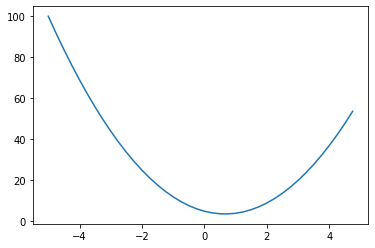

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
# derivative at any point
# let's take an example
h = 0.000001
x = 3.0
(f(x+h)-f(x))/h

14.000003002223593

In [ ]:
h = 0.000001
x = -3.0
(f(x+h)-f(x))/h

-21.999997002808414

- Let's create a class `Value`

In [114]:
class Value:

  # giving attribute to the Value objects
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  # representing the Value objects
  def __repr__(self):
    return f"Value(data={self.data})"

  # method of adding Value objects
  # in the name of functions like `__add__` you have to use double underscore methods to define these operators for these objects.
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Now we can directly add any number. e.g. a + 1
    out = Value(self.data + other.data, (self, other), '+') # storing tuple in _children

    def _backward():
      self.grad += 1.0 * out.grad # In addition, local dervative of self is 1.0 
      other.grad += 1.0 * out.grad # In addition, local dervative of self is 1.0 
    out._backward = _backward

    return out

  # method of multiplying Value objects
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Now we can directly multiply any number. e.g. a * 4
    out = Value(self.data * other.data, (self, other), '*') # storing tuple in _children

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  # power 
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward

  # rmul is like fallback so if python can't do 2 times a it will check if a times 2 can happen or not and if yes, it will provide a times 2 as answer.
  def __rmul__(self, other): # other * self
    return self * other

  # division
  def __truediv__(self, other): # self / other
    return self * other**-1

  # negative of self
  def __neg__(self): # -self
    return self * -1
  
  # subtraction
  def __sub__(self, other): # self - other
    return self + (-other)

  # method of defining tanh function
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  # defining exponential for Value object
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  # Below `backward` function is going to make `grad` for all the nodes before the `self` node:
  def backward(self):

    # Making topological order,
    topo = []
    visited = set()
    def build_topo(v): # Here v is from where we are starting the backward propagation . e.g. `L` or `self`.
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self) # starting point is `self`.

    # initializing `self.grad`:
    self.grad = 1.0

    # back propagating in reversed order:
    for node in reversed(topo):
      node._backward()
      
  

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
a + b  # computer will call a.__add__(b) to add this
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

In [88]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [89]:
d._op # how d is created from it's childrens, the operator used in between childrens of d to create d.

'+'

* defining a function `draw_dot()` that builds a graph for a node, show node's children and show operators used in between childrens to form the node.
For example, try *draw_dot(d)*

In [90]:
#@title 
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular {'record'} node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

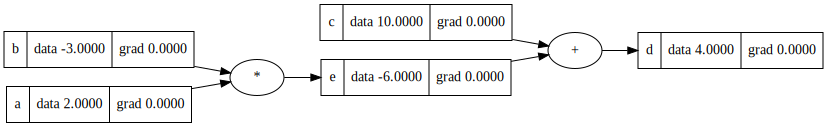

In [91]:
draw_dot(d)

In [92]:
f = Value(-2.0, label='f')
L = d * f; L.label= 'L'
L

Value(data=-8.0)

* INITIAL STAGE 

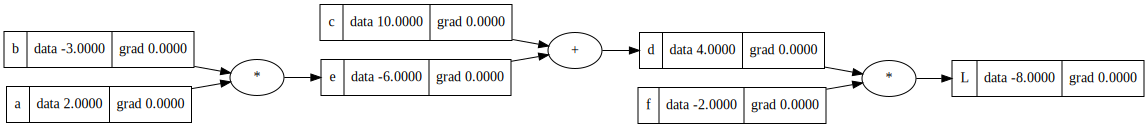

In [93]:
draw_dot(L)

* Now, Starting from `L` we will do back propagation and find the gradient descent , derivative of `L` w.r.t `L`, w.r.t `f`, w.r.t `d`, w.r.t `c` and all

In [94]:
def lol():

  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h # L2 is changing by small amount

  print((L2 - L1)/h)

lol()


1.000000000000334


### Manually doing Backpropagation

* First

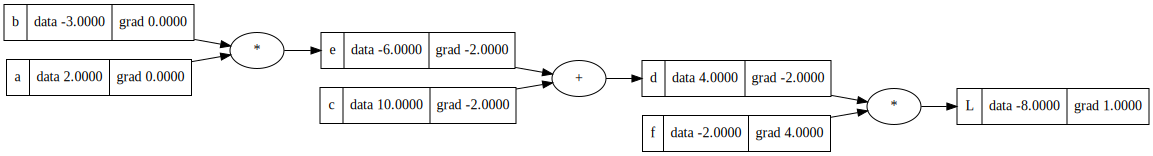

In [86]:
# Manually assigning L.grad.. manual backprop
# derivative of L w.r.t L is 1.0
L.grad = 1.0
draw_dot(L)

* Second

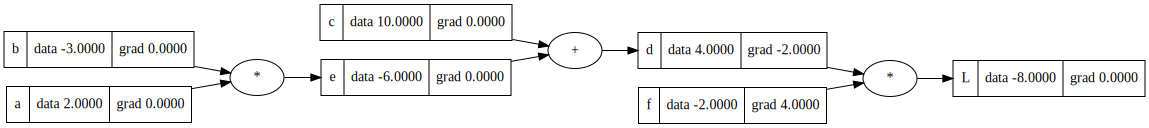

In [95]:
# Since L = f * d
# derivative of L w.r.t f is d
# derivative of L w.r.t d is f
f.grad = d.data
d.grad = f.data
draw_dot(L)


* Third

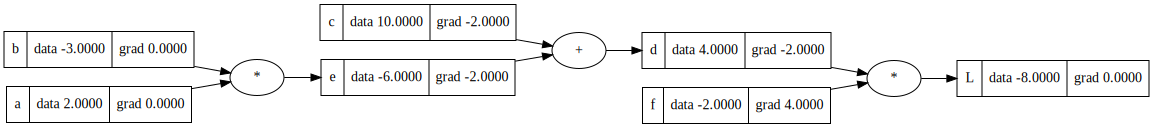

In [96]:
# since now for L w.r.t c or e.
# Clearly c and e children of d. so by chain rule , dL/dc = dL/dd * dd/dc = f 
# and similarly dL/de = f
c.grad = f.data
e.grad = f.data
draw_dot(L)

* Fourth

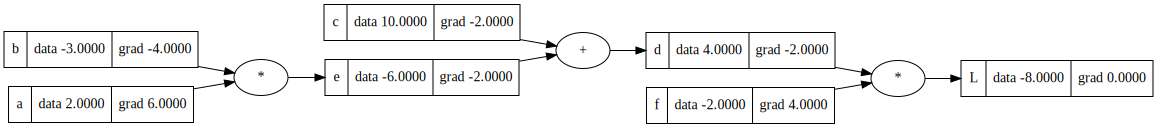

In [97]:
# Now for dL/da = dL/dd * dd/de * de/da = f * 1.0 * b = 6.0
# Similarly dL/db = f * a = -4.0
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

`NOTE`: we iterated through all nodes going backwards and finding derivatives of `L` w.r.t all nodes (known as `gradient descent`). This whole process is `Back propagation`

* Now, using `grad` values, we change the values of each node including L. 
 

That is, before going for next whole `back propagation` (next `epoch`)
* if `Learning rate` is 0.01. (Say)


In [98]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


### Programming Backpropagation

* See `Value class` we have added the Backward code.

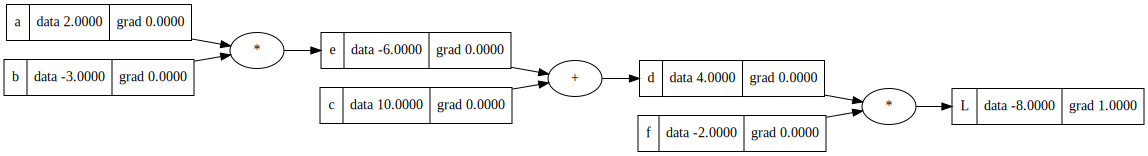

In [101]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d * f; L.label = 'L'
L.grad = 1.0
draw_dot(L)

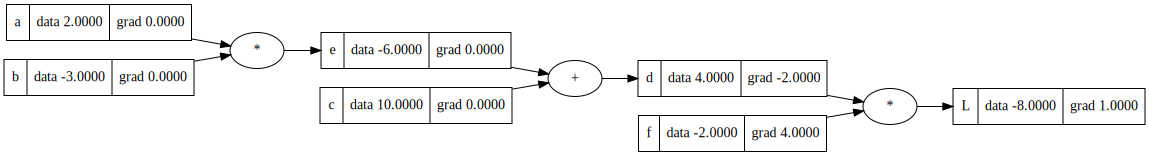

In [102]:
L._backward()
draw_dot(L)

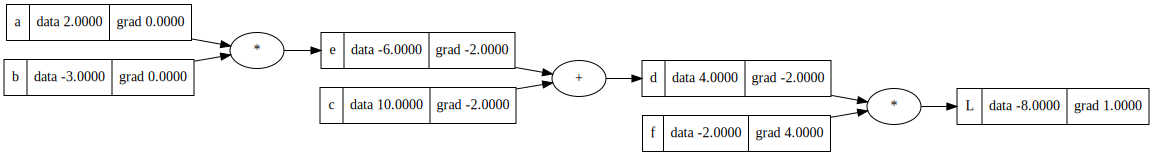

In [103]:
d._backward()
draw_dot(L)

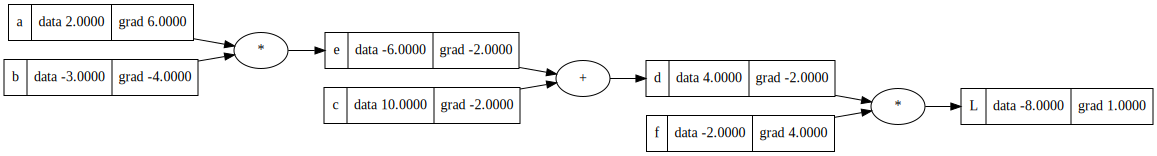

In [104]:
e._backward()
c._backward()
draw_dot(L)

##### TOPOLOGICAL SORT

In [105]:
# This builds a topological graph:
topo = []
visited = set()
def build_topo(v): # Here v is from where we are starting the backward propagation . e.g. `L`
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(L)
topo

[Value(data=10.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=4.0),
 Value(data=-2.0),
 Value(data=-8.0)]

#### Using `Topological graph` in `backpropagation algorithm`

In [110]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [111]:
L.grad = 1.0 # initially derivative of `L` w.r.t `L`

# Now by observation we have seen that we back propagate in reversed topological order,

# Making topological order,
topo = []
visited = set()
def build_topo(v): # Here v is from where we are starting the backward propagation . e.g. `L`
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(L) # starting point is L.

# back propagating in reversed order:
for node in reversed(topo):
  node._backward()
  


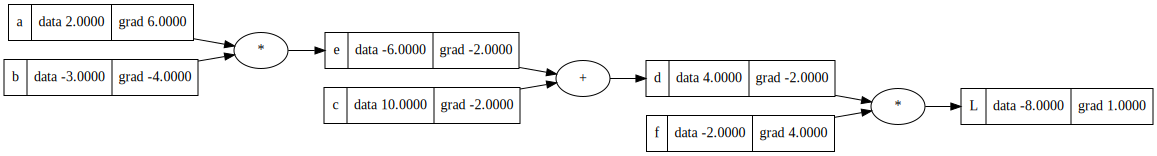

In [112]:
draw_dot(L)

* Adding this algorithm in `Value` Class